<a href="https://colab.research.google.com/github/Seonghoon-Yu/PyTorch_study/blob/main/ch04/ch04_Single_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('cookbook')


Mounted at cookbook


# Data 분석

In [2]:
import os
import pandas as pd

# loading Fovea_location.xlsx
path2data = '/content/cookbook/MyDrive/data'

path2labels = os.path.join(path2data, 'Training400', 'Fovea_location.xlsx')

# make sure to install xlrd
labels_df = pd.read_excel(path2labels, index_col='ID')

# print out its head
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [3]:
# print out its tails
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


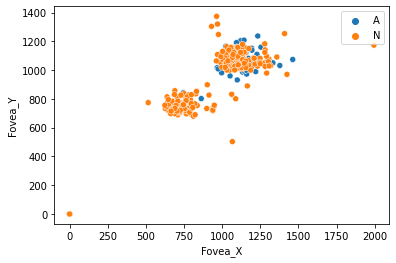

In [4]:
# show the scatter plot of the Fovea_X and Fovea_Y coordinates
import seaborn as sns
%matplotlib inline

AorN = [imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'], hue=AorN)


In [5]:
# show a few sample images
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

# set the plot parameters
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows, ncols=2, 3

# select a random set of image ids
imgName = labels_df['imgName']
ids = labels_df.index
rndIds = np.random.choice(ids, nrows * ncols)
print(rndIds)

[ 73 371 160 294 217 191]


<Figure size 1080x648 with 0 Axes>

In [6]:
# define a helper function to load an image and its label from the local files
def load_img_label(labels_df, id_):
    imgName = labels_df['imgName']
    if imgName[id_][0] == 'A':
        prefix = 'AMD'
    else:
        prefix = 'Non-AMD'

    fullPath2img = os.path.join(path2data, 'Training400', prefix, imgName[id_])
    img = Image.open(fullPath2img)
    x = labels_df['Fovea_X'][id_]
    y = labels_df['Fovea_Y'][id_]
    label = (x, y)
    return img, label

# define a helper function to show the image and label as a bounding box
def show_img_label(img, label, w_h=(50, 50), thickness=2):
    w,h = w_h
    cx, cy = label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline='green', width=thickness)
    plt.imshow(np.asarray(img))

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


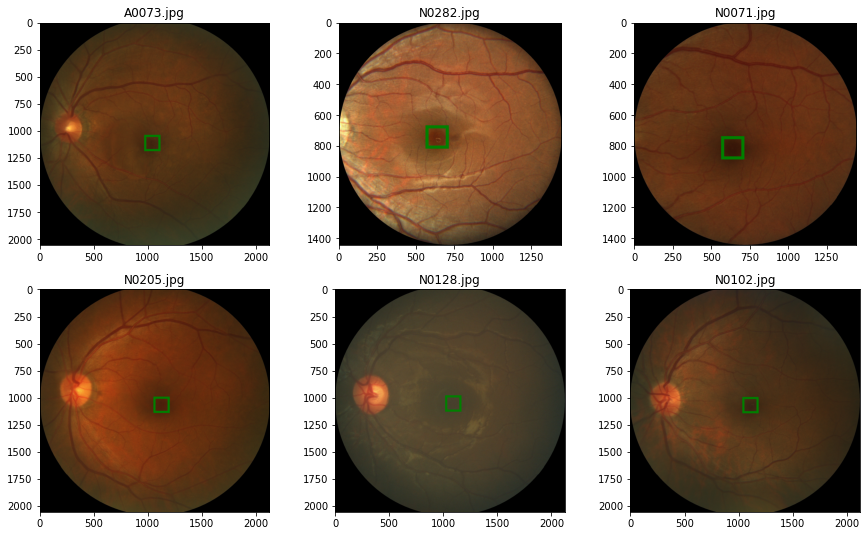

In [7]:
# show the selected images together with the fovea bounding boxes
for i, id_ in enumerate(rndIds):
    img, label = load_img_label(labels_df, id_)
    print(img.size, label)
    plt.subplot(nrows, ncols, i+1)
    show_img_label(img, label, w_h=(150,150), thickness=20)
    plt.title(imgName[id_])

In [8]:
# collect the image widths and heights in two lists
h_list, w_list = [], []
for id_ in ids:
    if imgName[id_][0] == 'A':
        prefix = 'AMD'
    else:
        prefix = 'Non-AMD'
    fullPath2img = os.path.join(path2data, 'Training400', prefix, imgName[id_])
    img = Image.open(fullPath2img)
    h, w = img.size
    h_list.append(h)
    w_list.append(w)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


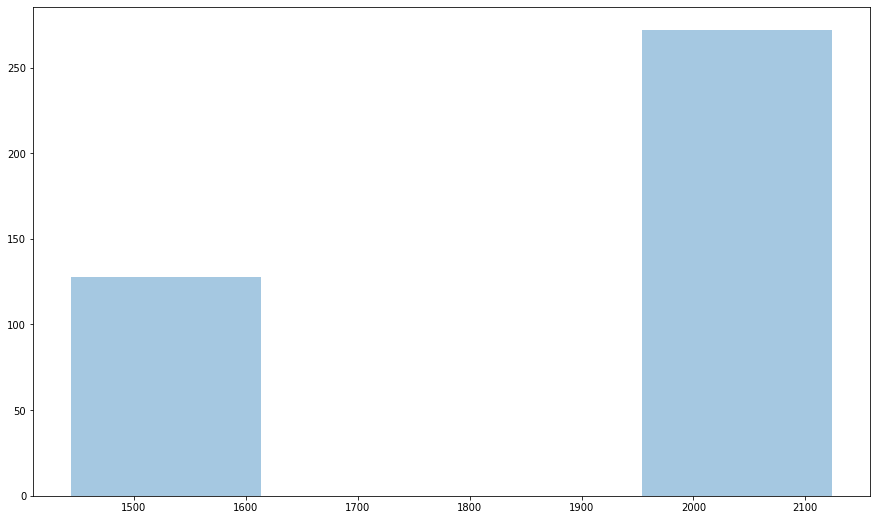

In [9]:
# plot the distributions of heights and widths

# plot the distribution of heights
sns.distplot(a=h_list, kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


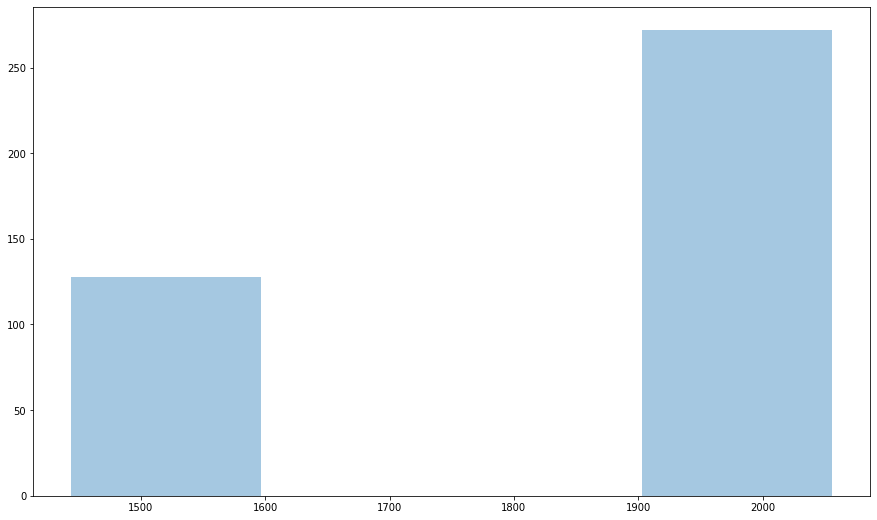

In [10]:
# plot the distributions of widths
sns.distplot(a=w_list, kde=False)

# Data transformation
image transformation을 수행함과 동시에 labels도 갱신해야 합니다.
이미지를 뒤집으면, 객체의 위치도 바뀌게 됩니다.

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


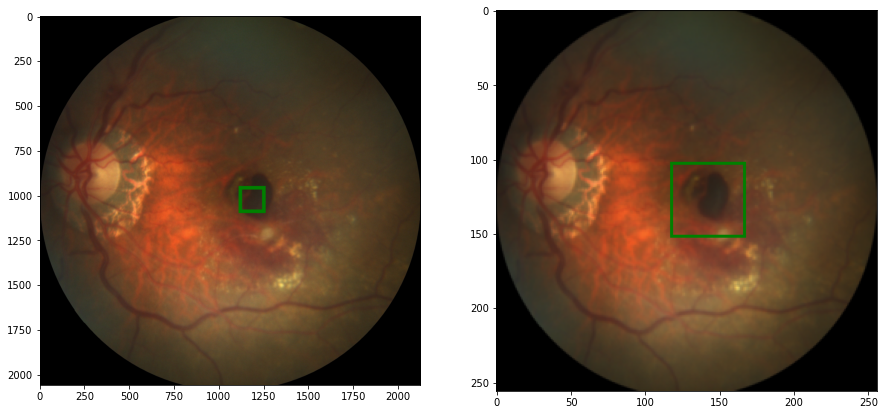

In [11]:
import torchvision.transforms.functional as TF
# create a data transformation pipeline for single-object detection

# define a helper function to resize images
def resize_img_label(image, label=(0., 0.), target_size=(256,256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx, cy = label
    image_new = TF.resize(image, target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    return image_new, label_new

# resize an image
img, label = load_img_label(labels_df, 1)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(img_r, label_r)

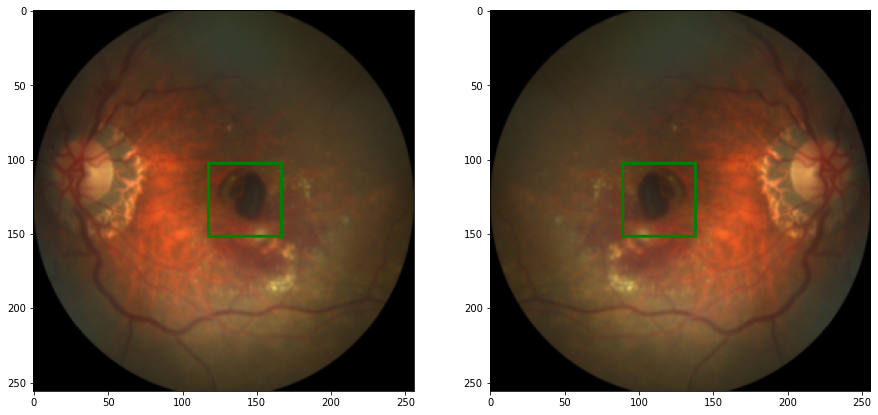

In [12]:
# define a helper function to randomly flip images horizontally
def random_hflip(image, label):
    w, h = image.size
    x, y = label

    image = TF.hflip(image)
    label = w-x, y
    return image, label

img, label = load_img_label(labels_df, 1)

img_r, label_r = resize_img_label(img, label)
img_fh, label_fh = random_hflip(img_r, label_r)

plt.subplot(1,  2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_fh, label_fh)

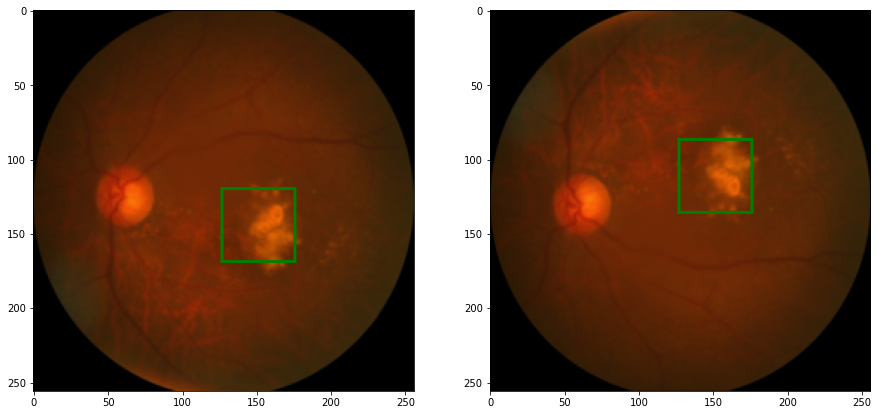

In [13]:
# define a function to randomly flip images vertically
def random_vflip(image, label):
    w, h = image.size
    x, y = label

    image = TF.vflip(image)
    label = x, w-y
    return image, label

img, label = load_img_label(labels_df, 7)
img_r, label_r = resize_img_label(img, label)
img_fv, label_fv = random_vflip(img_r, label_r)

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)

plt.subplot(1, 2, 2)
show_img_label(img_fv, label_fv)

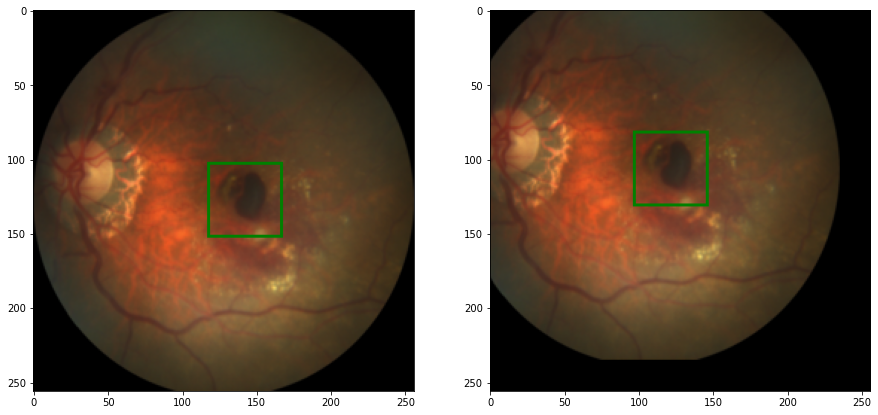

In [14]:
# define a helper function to randomly shift or translate images in either direction
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate=(0.2, 0.2)):
    w, h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand() * 2 - 1
    w_t = int(trans_coef * max_t_w * w)
    h_t = int(trans_coef * max_t_h * h)
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    label = cx + w_t, cy + h_t
    return image, label

img, label = load_img_label(labels_df, 1)
img_r, label_r = resize_img_label(img, label)
img_t, label_t = random_shift(img_r, label_r, max_translate=(0.5, 0.5))

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)

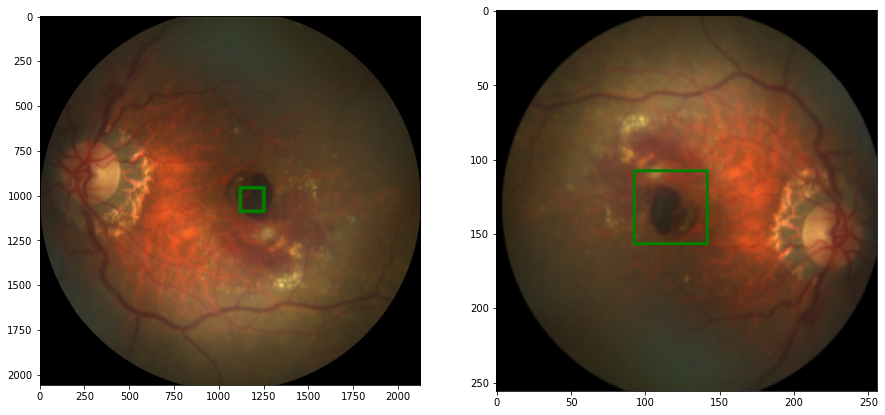

In [15]:
# compose multiple transformations into one function to define transformer
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params['target_size'])
    if random.random() < params['p_hflip']:
        image, label = random_hflip(image, label)
    if random.random() < params['p_vflip']:
        image, label = random_vflip(image, label)
    if random.random() < params['p_shift']:
        image, label = random_shift(image, label, params['max_translate'])
    image = TF.to_tensor(image)
    return image, label

# transform an image using transformer
import random
np.random.seed(0)
random.seed(0)

img, label = load_img_label(labels_df, 1)

params = {
    'target_size' : (256, 256),
    'p_hflip' : 1.0,
    'p_vflip' : 1.0,
    'p_shift' : 1.0,
    'max_translate' : (0.2, 0.2),
}

img_t, label_t = transformer(img, label, params)

# show the original and transformed images
plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(TF.to_pil_image(img_t), label_t)

In [16]:
# scale the labels
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

In [17]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

In [18]:
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)

In [19]:

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}
img_t,label_t=transformer(img,label,params)

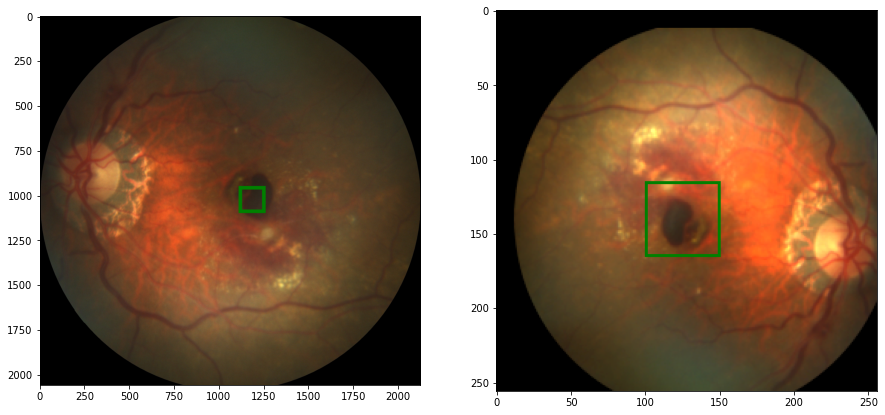

In [20]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

In [21]:
# rescale the label back to the original image
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

# Custom datasets 생성하기

In [22]:
# create the training and validation datasets and the data loaders
from torch.utils.data import Dataset
from PIL import Image

class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.labels)
      
    def __getitem__(self, idx):
        pass

        
def __init__(self, path2data, transform, trans_params):
    path2labels = os.path.join(path2data, 'Training400', 'Fovea_location.xlsx')
    labels_df = pd.read_excel(path2labels, index_col='ID')
    self.labels = labels_df[['Fovea_X', 'Fovea_Y']].values

    self.imgName = labels_df['imgName']
    self.ids = labels_df.index

    self.fullPath2img = [0] * len(self.ids)
    for id_ in self.ids:
        if self.imgName[id_][0] == 'A':
            prefix = 'AMD'
        else:
            prefix = 'Non-AMD'
        self.fullPath2img[id_-1] = os.path.join(path2data, 'Training400', prefix, self.imgName[id_])
    
    self.transform = transform
    self.trans_params = trans_params

def __len__(self):
    # return size of dataset
    return len(self.labels)

def __getitem__(self, idx):
    image = Image.open(self.fullPath2img[idx])
    label = self.labels[idx]
    image, label = self.transform(image, label, self.trans_params)

    return image, label

# override the dataset class functions
AMD_dataset.__init__ = __init__
AMD_dataset.__getitem__ = __getitem__

In [23]:
# create two objects of AMD_dataset

# define the transformation parameters for the training dataset
trans_params_train = {
    'target_size' : (256, 256),
    'p_hflip' : 0.5,
    'p_vflip' : 0.5,
    'p_shift' : 0.5,
    'max_translate' : (0.2, 0.2),
    'p_brightness' : 0.5,
    'brightness_factor' : 0.2,
    'p_contrast' : 0.5,
    'contrast_factor' : 0.2,
    'p_gamma' : 0.5,
    'gamma' : 0.2,
    'scale_label' : True,
}

# define the transformation parameters for the validation dataset
trans_params_val = {
    'target_size' : (256, 256),
    'p_hflip' : 0.0,
    'p_vflip' : 0.0,
    'p_shift' : 0.0,
    'p_brightness' : 0.0,
    'p_contrast' : 0.0,
    'p_gamma' : 0.0,
    'gamma' : 0.0,
    'scale_label' : True,
}

# two objects of the AMD_dataset class
amd_ds1 = AMD_dataset(path2data, transformer, trans_params_train)
amd_ds2 = AMD_dataset(path2data, transformer, trans_params_val)

In [24]:
# split the dataset into training and validation sets

# split the image indices into two groups
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print('-'*10)
    print(len(val_index))

320
----------
80


In [25]:
# define training and validation datasets
from torch.utils.data import Subset

train_ds = Subset(amd_ds1, train_index)
print(len(train_ds))

val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

320
80


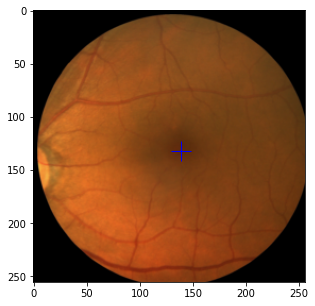

In [26]:
# show a sample image from train_ds and val_ds

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

# define a function to show a tensor image and its label
def show(img, label=None):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if label is not None:
        label = rescale_label(label, img.shape[1:])
        x, y = label
        plt.plot(x, y, 'b+', markersize=20)

# show a samplt image grom train_ds
plt.figure(figsize=(5,5))
for img, label in train_ds:
    show(img, label)
    break

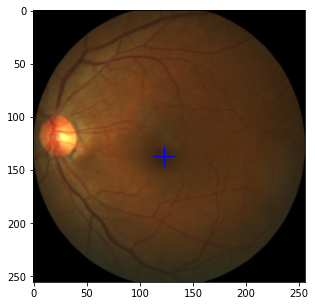

In [27]:
plt.figure(figsize=(5,5))
for img, label in val_ds:
    show(img, label)
    break

In [28]:
# define two data loaders for the training and validation datasets
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

# get a batch of data from train_dl
for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.5745, 0.4652, 0.4670, 0.5201, 0.6935, 0.4371, 0.5274, 0.4965],
       dtype=torch.float64), tensor([0.6299, 0.5297, 0.5657, 0.4206, 0.6696, 0.5541, 0.5274, 0.5415],
       dtype=torch.float64)]


In [29]:
# label batch is returned as a list
# Thus, nedd to convert the list to a tensor
import torch

# extract a batch from training data
for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)

    # convert list to tensor
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape, label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


In [30]:
# get a batch from val_dl
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)

    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


# model 생성하기
 convolutional layer, pooling layer, skip connection을 활용하여 model을 생성합니다. 

In [31]:
# implement the model class
import torch.nn as nn
import torch.nn.functional as F

# define the bulk of the model class
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()

        C_in, H_in, W_in = params['input_shape']
        init_f = params['initial_filters']
        num_outputs = params['num_outputs']

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)

    def forward(self, x):
        identity = F.avg_pool2d(x, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        x = F.relu(self.conv5(x))
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        return x

In [32]:
# define an object of the Net class
params_model = {
    'input_shape': (3, 256, 256),
    'initial_filters': 16,
    'num_outputs': 2,
}

model = Net(params_model)

In [33]:
# move the model to the CUDA device
if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


In [34]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 256, 256), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
            Conv2d-2           [-1, 32, 64, 64]           5,504
            Conv2d-3           [-1, 64, 32, 32]          29,440
            Conv2d-4          [-1, 128, 16, 16]         132,608
            Conv2d-5            [-1, 256, 8, 8]         560,128
            Linear-6                    [-1, 2]             514
Total params: 728,642
Trainable params: 728,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 3.88
Params size (MB): 2.78
Estimated Total Size (MB): 7.40
----------------------------------------------------------------


# loss, optimizer, IOU metric 정의하기

In [37]:
# define the loss function
loss_func = nn.SmoothL1Loss(reduction='sum')

# try out the loss with known value
n, c = 8, 2
y = 0.5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0
24.0


In [39]:
# define the optimizer
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

# define a helper function to read the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr = {}'.format(current_lr))

current lr = 0.0003


In [40]:
# define a learning rate schedule
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

# try it out
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


In [42]:
# define a function to compute the IOU for a batch of data

# define a helper function to convert coordinates to a bounding box
def cxcy2bbox(cxcy, w=50./256, h=50./256):
    w_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * w
    h_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * h
    cx = cxcy[:,0].unsqueeze(1)
    cy = cxcy[:,1].unsqueeze(1)
    boxes = torch.cat((cx, cy, w_tensor, h_tensor), -1) # cx, cy, w, h
    return torch.cat((boxes[:,:2] - boxes[:, 2:]/2, boxes[:, :2] + boxes[:, 2:]/2), 1) # xmin, ymin, xmax, ymax

# try out the function
torch.manual_seed(0)

cxcy = torch.rand(1, 2)
print('center:', cxcy*256)

bb = cxcy2bbox(cxcy)
print('bounding box', bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [44]:
# define the metric function
import torchvision
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    iou = torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item() # return diagonal term of matrix

# try it
n, c = 8, 2
target = torch.rand(n, c, device = device)
target = cxcy2bbox(target)
metrics_batch(target, target)

8.0

In [45]:
# define the loss_batch function
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

# try the loss_batch function
for xb, label_b in train_dl:
    label_b = torch.stack(label_b, 1)
    label_b = label_b.type(torch.float32)
    label_b = label_b.to(device)

    l, m = loss_batch(loss_func, label_b, label_b)
    print(l, m)
    break

0.0 8.0


# 모델 학습(Training)과 평가(Evaluation)

In [50]:
# define a loss_epoch helper function
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0
    running_metric = 0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        yb = torch.stack(yb, 1)
        yb = yb.type(torch.float32).to(device)
        output = model(xb.to(device))
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break
        
    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

In [51]:
# define a train_val function
import copy

def train_val(model, params):
    # extract parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [53]:
loss_func=nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.015766, accuracy: 27.93
val loss: 0.010615, accuracy: 44.03
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.010449, accuracy: 36.01
val loss: 0.009821, accuracy: 57.10
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.009324, accuracy: 37.76
val loss: 0.009514, accuracy: 50.39
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.007425, accuracy: 43.20
val loss: 0.009365, accuracy: 51.47
----------
Epoch 4/9, current lr=0.0001
train loss: 0.007202, accuracy: 41.98
val loss: 0.010564, accuracy: 39.56
----------
Epoch 5/9, current lr=0.0001
train loss: 0.005714, accuracy: 46.21
val loss: 0.009526, accuracy: 62.49
----------
Epoch 6/9, current lr=0.0001
train loss: 0.005431, accuracy: 47.70
val loss: 0.011096, accuracy: 35.92
----------
Epoch 7/9, current lr=0.0001
train loss: 0.005448, accuracy: 47.03
val loss: 0.010853, accurac

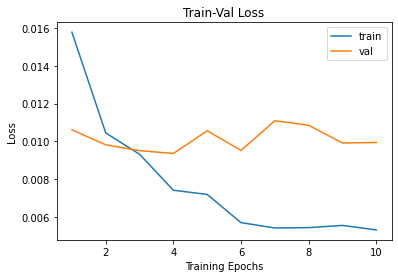

In [54]:
# plot the training and validation loss
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

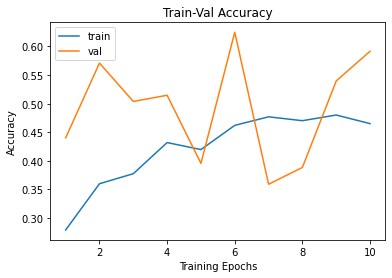

In [55]:
# plot accuracy
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# 모델 테스트
test dataset이 없기 때문에, validation dataset을 test에 사용합니다.

In [56]:
# create an object of the Net class

params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }

model = Net(params_model)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [58]:
# move the model to the CUDA device
if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)

In [61]:
# load the model parameters from the files
path2weights = "/content/models/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [62]:
# verify the model by testing on the validation dataset
loss_func = nn.SmoothL1Loss(reduction='sum')

with torch.no_grad():
    loss,metric=loss_epoch(model,loss_func,val_dl)
print(loss,metric)

0.009365144418552518 0.5147240161895752


In [63]:
# test the model on the image samples from val_ds

from PIL import ImageDraw
import numpy as np
import torchvision.transforms.functional as tv_F
np.random.seed(0)

import matplotlib.pylab as plt
%matplotlib inline

In [69]:
# define a function to display a tensor with two labels as bounding boxes

def show_tensor_2labels(img, label1, label2, w_h=(50, 50)):
    label1 = rescale_label(label1, img.shape[1:])
    label2 = rescale_label(label2, img.shape[1:])
    img = tv_F.to_pil_image(img)

    w, h = w_h
    cx, cy = label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline='green', width=2)

    cx, cy = label2
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline='red', width=2)

    plt.imshow(np.asarray(img))

In [70]:
# get random samples
rndInds = np.random.randint(len(val_ds), size=10)
print(rndInds)

[58 65 39 46 37 25 77 72  9 20]


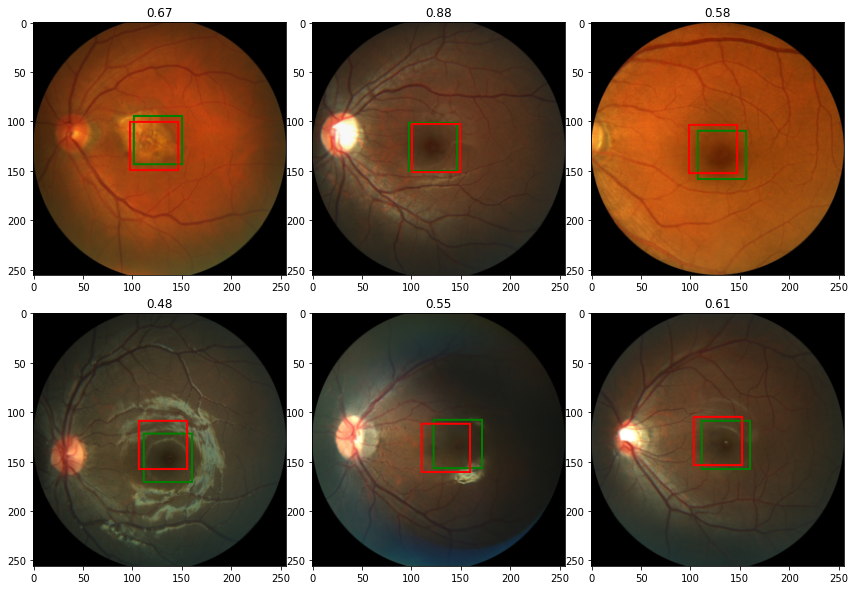

In [71]:
# test the model in the samples and display the predictions together with the ground truth
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.15)

for i, rndi in enumerate(rndInds):
    img, label = val_ds[rndi]
    h, w = img.shape[1:]
    with torch.no_grad():
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
    
    plt.subplot(2, 3, i+1)
    show_tensor_2labels(img, label, label_pred)

    # calculate IOU
    label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0))
    label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0))
    iou = torchvision.ops.box_iou(label_bb, label_pred_bb)
    plt.title('%.2f' %iou.item())

    if i > 4:
        break

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256]) [0.5566215996187523, 0.4970908762590175]


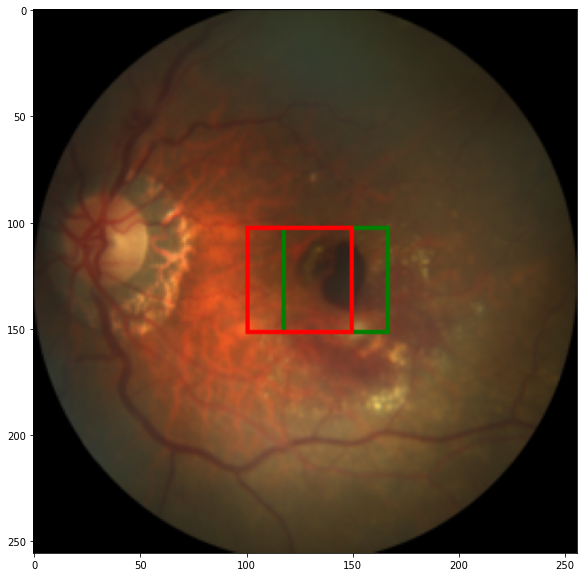

In [75]:
# test the model on individual images
path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")
labels_df=pd.read_excel(path2labels,index_col="ID")

img,label=load_img_label(labels_df,1)   
print(img.size, label)

img,label=resize_img_label(img,label,target_size=(256,256))
print(img.size, label)

img=TF.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape, label)

with torch.no_grad():
    label_pred = model(img.unsqueeze(0).to(device))[0].cpu()

show_tensor_2labels(img, label, label_pred)

In [76]:
# calculate the inference time per image
import time
elapsed_times = []
with torch.no_grad():
    for k in range(100):
        start = time.time()
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
        elapsed = time.time()-start
        elapsed_times.append(elapsed)

print('inference time per image: %.4f s' %np.mean(elapsed_times))

inference time per image: 0.0013 s
